# Aprendizaje No Supervisado

## Clustering con K Means  

En esta notebook aplicaremos tecnicas de Clustering sobre el dataset de airbnb.  
  
En particular, utilizaremos __KMeans__, para clusterizar el conjunto de datos __train_users__

Utilizaremos un subconjunto de features del dataset original, para poder explorar y visualizar como quedan conformados los clusters.  

Exploraremos distintas metricas para poder evaluar los clusters conformados.

Luego, iremos agregando features, continuando con el analisis de las metricas.  

Finalmente, presentaremos algunas conclusiones sobre los reultados obtenidos.  

### Normalización de los datos

En esta notebook, normalizamos las features __age__ y __gender__.  
En el caso de __age__ normalizamos utilizando max/mix.
En __gender__ utilizamos get_dummies para generar variables dicotomicas.



In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import itertools

from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score


from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

import warnings

%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset_path = "..//datos//"
abnb_users_curated_file = "modified_train_users.csv"

In [8]:
users_df = pd.read_csv( dataset_path + abnb_users_curated_file )

In [9]:
print('The dataset contains: ', len(users_df),' users.')

The dataset contains:  121070  users.


In [10]:
users_df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,1,38.0,1,0,5,...,6,2,3,7,0,0.0,0.0,1,1,True
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,6,2,6,14,1,0.0,0.0,1,1,True
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,6,2,3,13,2,0.0,0.0,1,1,True
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,6,2,3,7,1,0.0,0.0,1,1,True
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,6,2,3,30,1,0.0,0.0,1,1,True


In [11]:
g = pd.get_dummies( users_df['gender'], prefix='gender')
g.head()

,gender_0,gender_1,gender_2
0,0,1,0
1,1,0,0
2,1,0,0
3,0,0,1
4,1,0,0


In [12]:
users_df = pd.concat( [users_df, g], axis=1 )
users_df.drop(['gender'], axis=1)

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,age,signup_method,signup_flow,language,affiliate_channel,...,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked,gender_0,gender_1,gender_2
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,38.0,1,0,5,7,...,7,0,0.0,0.000000,1,1,True,0,1,0
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,56.0,0,3,5,2,...,14,1,0.0,0.000000,1,1,True,1,0,0
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,42.0,1,0,5,2,...,13,2,0.0,0.000000,1,1,True,1,0,0
3,4,87mebub9p4,1284422400,1260252665,1266451200,41.0,0,0,5,2,...,7,1,0.0,0.000000,1,1,True,0,0,1
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,46.0,0,0,5,3,...,30,1,0.0,0.000000,1,1,True,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121065,213441,omlc9iku7t,1404086400,1404172311,1407888000,34.0,0,0,5,2,...,7,6,527228.0,16475.875000,32,2,True,1,0,0
121066,213443,0k26r3mir0,1404086400,1404172420,1405209600,36.0,0,0,5,5,...,30,1,5104968.0,38383.218045,133,1,True,1,0,0
121067,213445,qbxza0xojf,1404086400,1404172547,1404259200,23.0,0,0,5,5,...,14,1,1460947.0,14047.567308,104,1,True,1,0,0
121068,213446,zxodksqpep,1404086400,1404172596,-9223372037,32.0,0,0,5,5,...,30,0,5142542.0,46750.381818,110,2,True,0,1,0


In [13]:
users_df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked,gender_0,gender_1,gender_2
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,1,38.0,1,0,5,...,7,0,0.0,0.0,1,1,True,0,1,0
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,14,1,0.0,0.0,1,1,True,1,0,0
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,13,2,0.0,0.0,1,1,True,1,0,0
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,7,1,0.0,0.0,1,1,True,0,0,1
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,30,1,0.0,0.0,1,1,True,1,0,0


In [25]:
users_df['age'] = users_df['age'].astype(int)


In [26]:
users_has_booked_df = users_df[ users_df['has_booked'] == True]

users_to_cluster_df = users_has_booked_df[ ['country_destination', 'age','gender_0', 'gender_1', 'gender_2',  'first_device_type']]

## TO SPEED UP...
users_to_cluster_df = users_to_cluster_df.sample(10000)

print( "Number of records: ", len(users_to_cluster_df))

users_to_cluster_df.head()

Number of records:  10000


,country_destination,age,gender_0,gender_1,gender_2,first_device_type
39296,0,22,1,0,0,3
22860,1,43,0,1,0,6
97510,1,40,0,1,0,6
111194,1,55,1,0,0,7
4963,0,47,0,1,0,3


In [27]:
# let us try to normalize the dataset
users_to_cluster_df['age'] = ((users_to_cluster_df['age']-users_to_cluster_df['age'].min())/(users_to_cluster_df['age'].max()-users_to_cluster_df['age'].min()))
users_to_cluster_df['age'].sample(10)


11577     0.297619
81428     0.416667
65395     0.190476
112949    0.095238
109849    0.476190
41190     0.345238
113569    0.059524
35514     0.273810
104416    0.095238
49166     0.488095
Name: age, dtype: float64

In [28]:
users_to_cluster_df.head()

,country_destination,age,gender_0,gender_1,gender_2,first_device_type
39296,0,0.083333,1,0,0,3
22860,1,0.333333,0,1,0,6
97510,1,0.297619,0,1,0,6
111194,1,0.476190,1,0,0,7
4963,0,0.380952,0,1,0,3


In [29]:
# Let's turn our dataset into a list
users_to_cluster = users_to_cluster_df.values

In [30]:
def add_cluster_to_dataset( original_df, predictions):
    return  pd.concat([original_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

# Generación de Clusters

## Metricas - Silhouette

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a __measure of how close each point in one cluster is to points in the neighboring clusters__ and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as):  
* near +1 indicate that the sample is far away from the neighboring clusters. 
* A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and   
* negative values indicate that those samples might have been assigned to the wrong cluster


k =  2


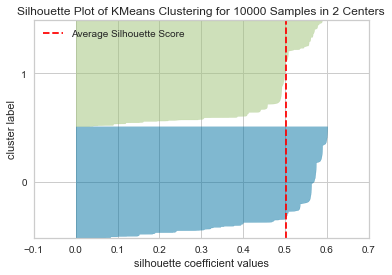

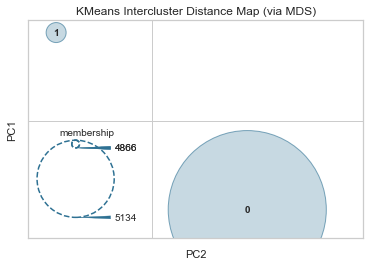


k =  3


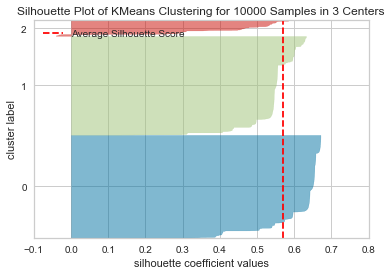

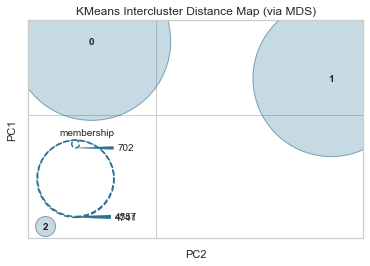


k =  4


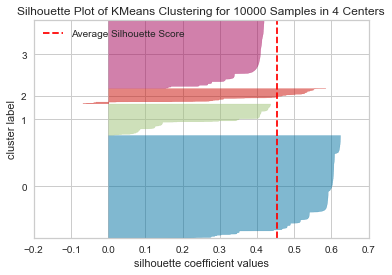

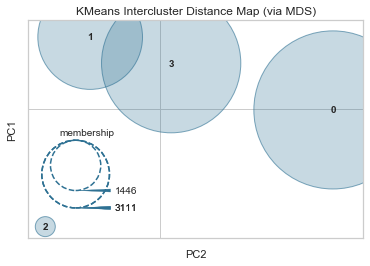


k =  5


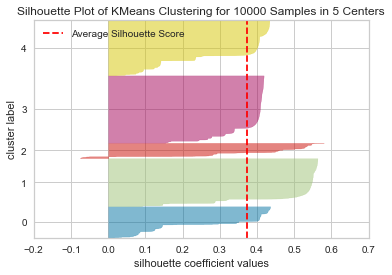

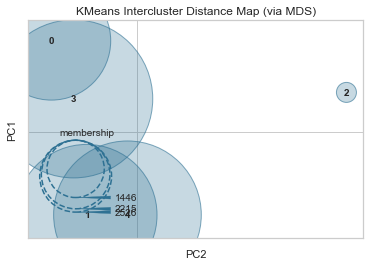

In [31]:
# Clusters to generate

k_sets = [2,3,4,5]

for k in k_sets:
    
    print("\nk = ", k)
    
    clusterer = KMeans( k, random_state=7 )
    
    predictions = clusterer.fit_predict( users_to_cluster )
 
    # print("Inertia: ", clusterer.inertia_ )
    # print("Centers: ", clusterer.cluster_centers_)

    visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')
    visualizer.fit(users_to_cluster)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

    # Instantiate the clustering model and visualizer
    visualizer = InterclusterDistance( clusterer )
    visualizer.fit(users_to_cluster)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

## Métricas - Elbow technique

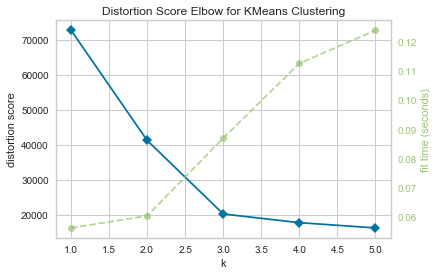

In [32]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,6) )
visualizer.fit( users_to_cluster )        # Fit the data to the visualizer
visualizer.show()   

## Conclusión análisis clusterización  

Tanto del analisis del grafico de Elbox, como de las Silhoutes, se observa que k = 3 es la mejor opcion para clusterizar los datos

## Analisis de los clusters para k=3

Intentamos visualizar como estan conformados los clusters (que elementos agrupa), para k = 2, que es la cantidad optima de clusters segun las metricas analizadas previamente.

In [33]:

clusterer = KMeans( 3, random_state=7 )
    
predictions = clusterer.fit_predict( users_to_cluster )

clustered = add_cluster_to_dataset(users_to_cluster_df, predictions)

clustered.head()


,index,country_destination,age,gender_0,gender_1,gender_2,first_device_type,group
0,39296,0,0.083333,1,0,0,3,0
1,22860,1,0.333333,0,1,0,6,1
2,97510,1,0.297619,0,1,0,6,1
3,111194,1,0.476190,1,0,0,7,1
4,4963,0,0.380952,0,1,0,3,0


### Verifiquemos el tamaño de cada cluster

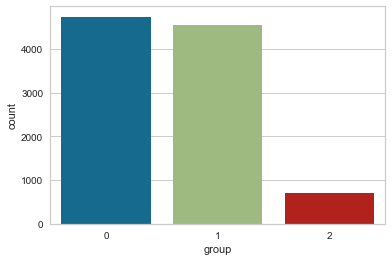

In [34]:
sns.countplot(data = clustered, x='group', )

### Feature __age__  

Observamos como se distribuyen los datos, en los clusters creados, en relación a la feature __age__

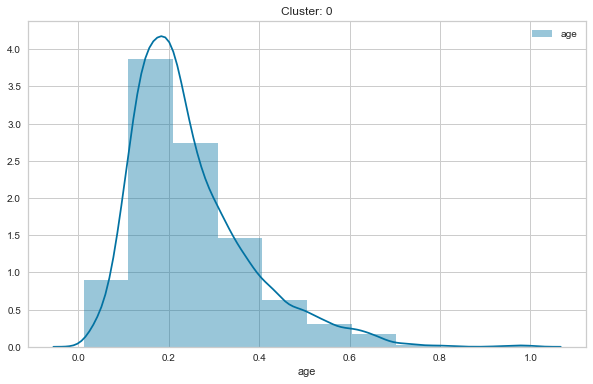

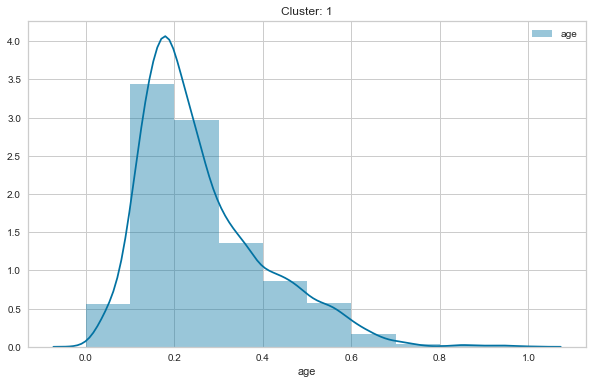

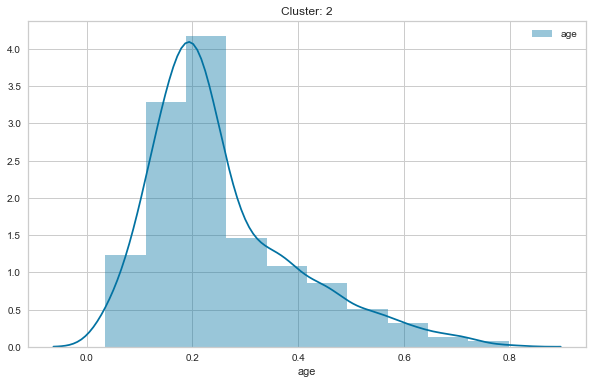

In [35]:
for cluster in range (0,3):
    
    cluster_to_show = clustered[ clustered['group'] == cluster]
    
    plt.figure(figsize=(10,6))
    sns.distplot(cluster_to_show['age'].dropna(), bins=10, label='age')
    plt.title('Cluster: ' + str(cluster) )
    plt.legend()

Relación __age__ y __gender_0__

En lo que sigue, solo tiene sentido ver el valor 1 (el 0 indica la ausencia de esa feature)

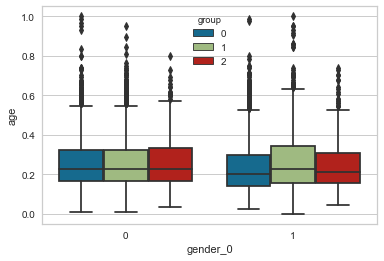

In [36]:
sns.boxplot(data = clustered, x='gender_0', y ='age' ,  hue='group' )

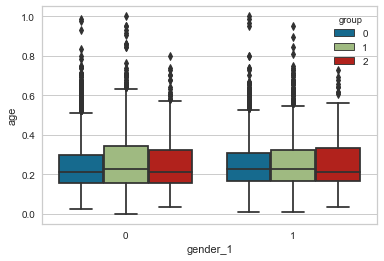

In [39]:
sns.boxplot(data = clustered, x='gender_1', y ='age' ,  hue='group' )

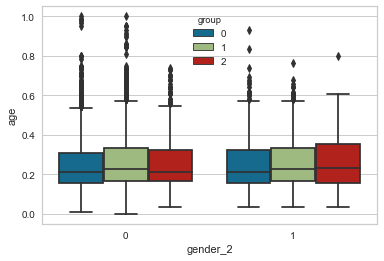

In [40]:
sns.boxplot(data = clustered, x='gender_2', y ='age' ,  hue='group' )

### Relación __age__ y __first_device_type__

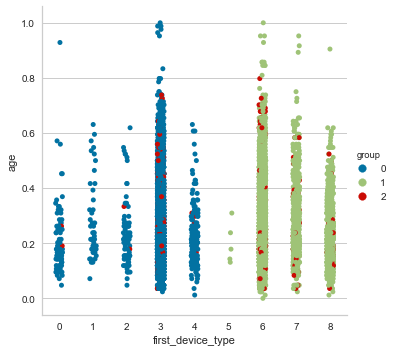

In [41]:
sns.catplot(y='age', x='first_device_type', data=clustered , hue='group' , jitter=True )

### Agrupamiento sobre __country_destination__

Intentamos observar si existe algun criterio de separación por __country_destination__

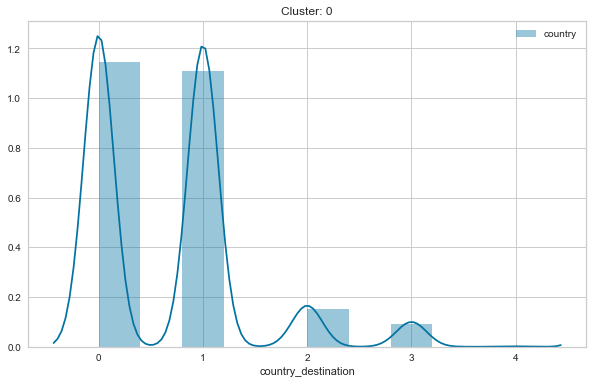

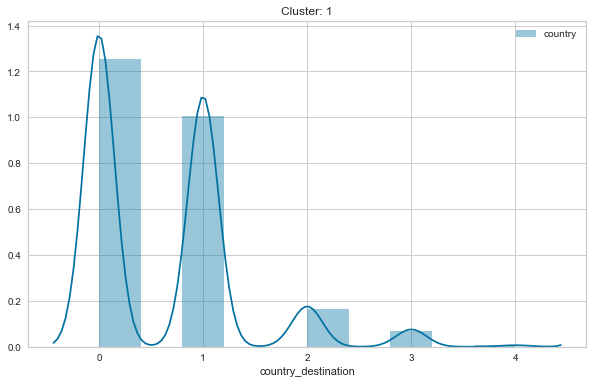

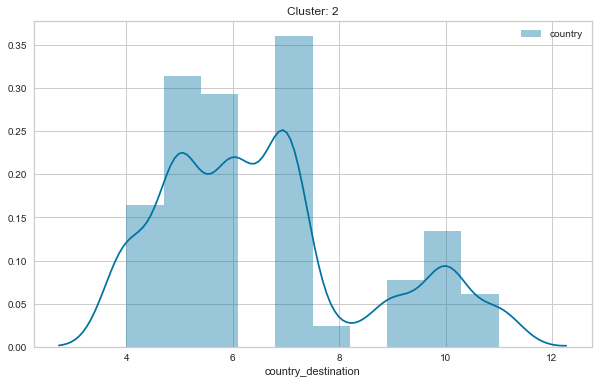

In [43]:
for cluster in range (0,3):
    
    cluster_to_show = clustered[ clustered['group'] == cluster]
    
    plt.figure(figsize=(10,6))
    sns.distplot(cluster_to_show['country_destination'].dropna(), bins=10, label='country')
    plt.title('Cluster: ' + str(cluster) )
    plt.legend()

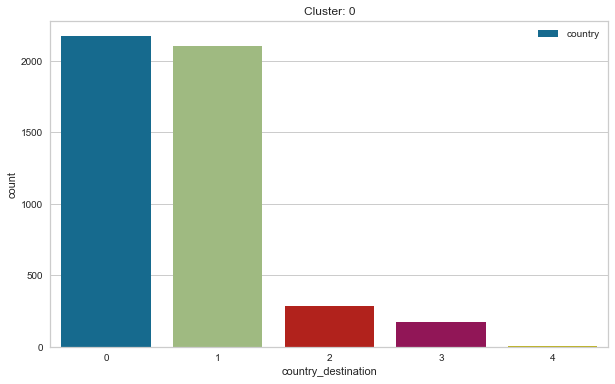

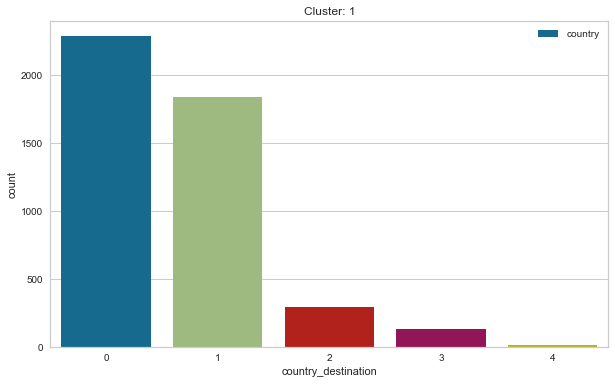

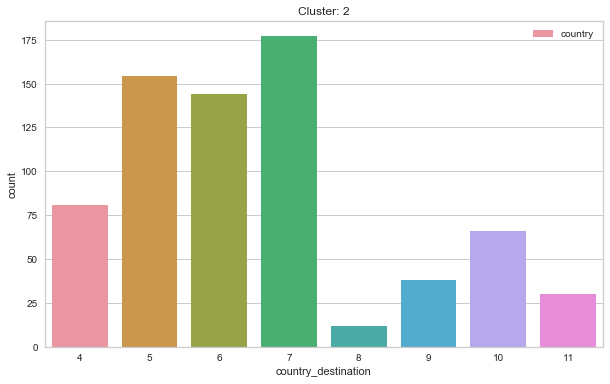

In [44]:
for cluster in range (0,3):
    
    cluster_to_show = clustered[ clustered['group'] == cluster]
    
    plt.figure(figsize=(10,6))
    sns.countplot(cluster_to_show['country_destination'].dropna(), label='country')
    plt.title('Cluster: ' + str(cluster) )
    plt.legend()

## Conclusiones  

En esta notebook, hemos hecho el ejercicio de clusterizacion, normalizando la feature __age__.

El resultado que se obtiene, es bastante diferente al que se logra al no normalizar.

En este caso, tenemos que k = 3 es la cantidad optima de clusters.

Se obtienen 2 clusters de tamaño similar, y un tercero bastante más chico.

Se observar que un cluster, el 0, agrupa a los __country_destination__ 'GB', 'ES', 'IT', 'PT', 'NL', 'DE', 'AU', mientras que los otros dos clusters contienen 'US', 'other', 'FR' y 'CA'.

__Age__ está distribuidos uniformemente entre los 3 clusters.

